### MRI Brain Tumour Segmentation using U-Net Deep Learning Model

References:
- https://github.com/adityajn105/brain-tumor-segmentation-unet/blob/master/brain_tumor_segmentation.ipynb

In [1]:
import matplotlib.pyplot as plt
from utils import *
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
""" Dataset Preparations """
# Parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
NUM_CLASSES = 4 

# Create ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,      # Random rotation up to 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of image width
    height_shift_range=0.1, # Random vertical shift by up to 10% of image height
    shear_range=0.2,        # Random shearing by up to 20%
    # zoom_range=0.1,         # Random zooming by up to 10%
    # zoom_range=[.9,1.1],    # Random zooming by up to 10% or down to 10%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest',    # Fill mode for pixels outside the input boundaries
    validation_split=0.2    # Split data into training and validation
)

# Create ImageDataGenerator for validation data (without augmentation)
valid_datagen = ImageDataGenerator(validation_split=0.2)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19032024
)

# Create validation generator
validation_generator = valid_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19032024
)

# Check the shape of your training data
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break


Found 380 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Shape of images batch: (32, 128, 128, 3)
Shape of labels batch: (32, 4)


In [3]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Training classes:", class_names)
class_names = list(validation_generator.class_indices.keys())
print("Validation classes:", class_names)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


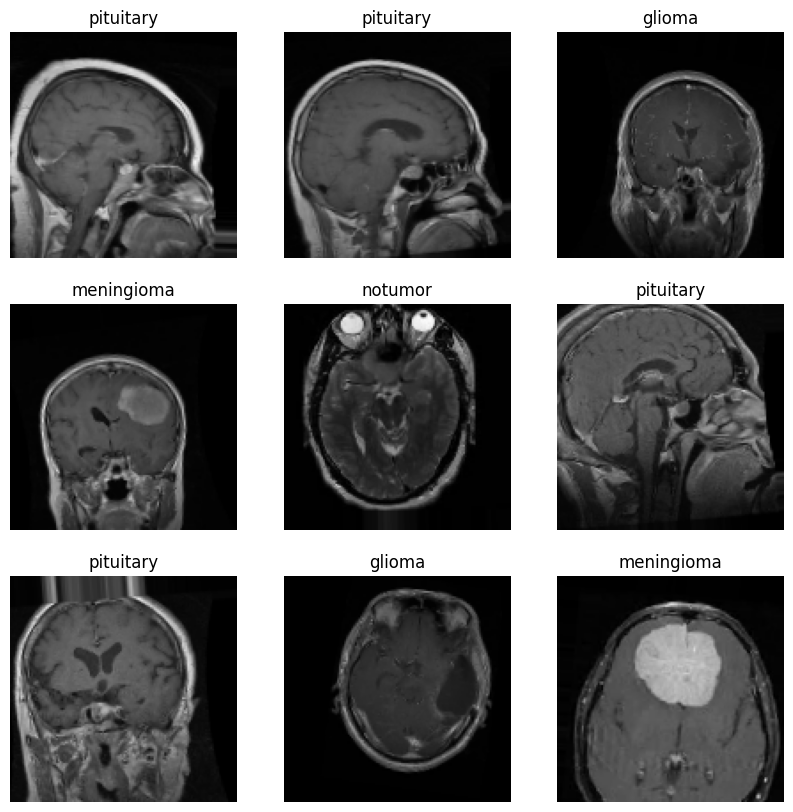

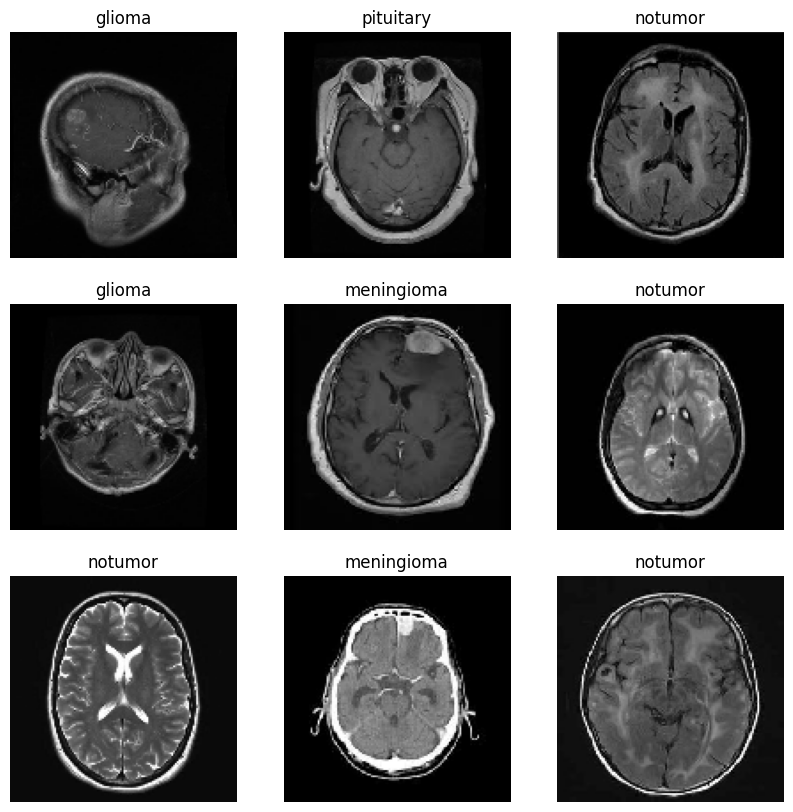

In [4]:
# Preview training dataset
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

# Preview validation dataset
plt.figure(figsize=(10, 10))
images, labels = next(validation_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

In [5]:
""" Create Model """
IMG_DIM = (128,128,3)
NUM_CLASSES = 4

def conv2d_block(input_tensor, n_filters, kernel_size=(3,3), name="contraction"):
    "Add 2 conv layers"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_2')(x)
    return x
  
inp = Input(shape=IMG_DIM)

# Encoder
d1 = conv2d_block(inp, 64, name="contraction_1")
p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block(p1, 128, name="contraction_2")
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block(p2, 256, name="contraction_3")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3, 512, name="contraction_4")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4, 512, name="contraction_5")

# Decoder
u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(d5)
u1 = concatenate([u1, d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c1)
u2 = concatenate([u2, d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c2)
u3 = concatenate([u3, d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 64, name="expansion_4")

# Final classification layer
flattened = Flatten()(c4)
out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)

unet = Model(inp, out)

unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_1     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_2     │ (None, 128, 128,  │     36,928 │ contraction_1_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ contraction_1_2[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1     │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_2     │ (None, 64, 64,    │    147,584 │ contraction_2_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ contraction_2_2[… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1     │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_2     │ (None, 32, 32,    │    590,080 │ contraction_3_1[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ contraction_3_2[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_4_1     │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0] 

 Total params: 26,913,924 (102.67 MB)

 Trainable params: 26,912,004 (102.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_best_checkpoint.keras', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Define callback list
callback_list = [reduceLR, model_checkpoint]

# Train the model
hist = unet.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback_list)

# Export latest model
unet.save(MODEL_FILE)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2377 - loss: 5141.5059
Epoch 1: val_loss improved from inf to 15.15959, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.2413 - loss: 5000.5176 - val_accuracy: 0.4105 - val_loss: 15.1596 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2823 - loss: 7.6669
Epoch 2: val_loss improved from 15.15959 to 1.50409, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.2846 - loss: 7.3973 - val_accuracy: 0.2947 - val_loss: 1.5041 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4098 - loss: 1.2965
Epoch 3: val_loss improved from 1.50409 to 1.32145, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.4117 - loss: 1.2959 - val_accuracy: 0.3789 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━

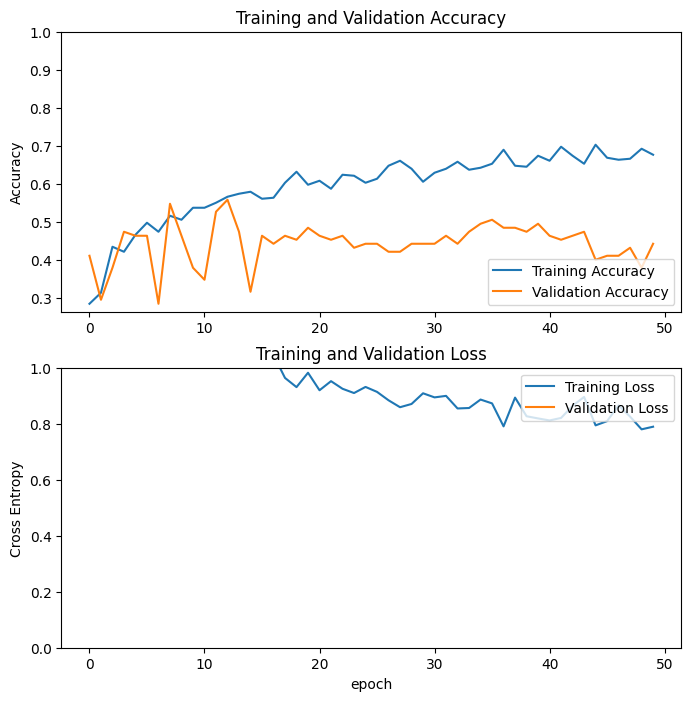

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4007 - loss: 1.4114
Test Accuracy : 0.4421052634716034
Test Loss : 1.3373826742172241
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4281 - loss: 1.3201
Validation Accuracy: 0.44


In [7]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = unet.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = unet.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


In [10]:
""" Model Performance """
# Load the best model
# model = keras.models.load_model('./models/unet_best_checkpoint.keras')

# Load the last model
model = keras.models.load_model('./models/unet_model.keras')

In [11]:
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Initialise predictions
list_train_pred = []
list_test_pred = []

for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (128, 128), verbose_output=1))
    
for image_path in x_test:
    print(image_path)
    list_test_pred.append(predict_class(image_path, model, class_names, (128, 128), verbose_output=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━

In [13]:
# Get model's training performance
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

Accuracy: 0.6657894736842105
Precision: 0.6790468249155333
Recall: 0.6667798913043478
F1 Score: 0.6666269875397397
Matthews Correlation Coefficient (MCC): 0.5572190151765248
Cohen's Kappa: 0.5544188794918197
Hamming Loss: 0.33421052631578946

Confusion Matrix:
 [[55 30  0 11]
 [12 51 19 14]
 [ 1 13 70  8]
 [ 0 11  8 77]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.81      0.57      0.67        96
  meningioma       0.49      0.53      0.51        96
     notumor       0.72      0.76      0.74        92
   pituitary       0.70      0.80      0.75        96

    accuracy                           0.67       380
   macro avg       0.68      0.67      0.67       380
weighted avg       0.68      0.67      0.67       380





In [14]:
# Get model's test performance
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

Accuracy: 0.5789473684210527
Precision: 0.588763197586727
Recall: 0.5810688405797102
F1 Score: 0.5707806151155905
Matthews Correlation Coefficient (MCC): 0.44561100183160485
Cohen's Kappa: 0.43878304534042234
Hamming Loss: 0.42105263157894735

Confusion Matrix:
 [[11  7  1  5]
 [ 4  8  3  9]
 [ 0  3 18  2]
 [ 0  2  4 18]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.73      0.46      0.56        24
  meningioma       0.40      0.33      0.36        24
     notumor       0.69      0.78      0.73        23
   pituitary       0.53      0.75      0.62        24

    accuracy                           0.58        95
   macro avg       0.59      0.58      0.57        95
weighted avg       0.59      0.58      0.57        95



